# Regime Detection Analysis

This notebook runs regime detection on all available data from `snapshot_latest` and `macro.parquet`,
generating a daily time series chart showing the detected market regime.

## Regime Classification

The regime detector classifies markets into 4 regimes based on:
- **Trend**: SPY vs 200-day moving average (with 2% hysteresis)
- **Volatility**: VIX level (high > 25, low < 20, with hysteresis)

| Regime | Trend | Volatility |
|--------|-------|------------|
| uptrend_low_vol | SPY > 200MA | VIX < 20 |
| uptrend_high_vol | SPY > 200MA | VIX > 25 |
| downtrend_low_vol | SPY < 200MA | VIX < 20 |
| downtrend_high_vol | SPY < 200MA | VIX > 25 |

In [1]:
import sys
from pathlib import Path

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

from quantetf.regime.detector import RegimeDetector
from quantetf.regime.types import RegimeConfig, RegimeState, TrendState, VolatilityState
from quantetf.data.snapshot_store import SnapshotDataStore

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## 1. Load Data

Load price data from `snapshot_latest` and macro data from `macro.parquet`.

In [2]:
# Define paths
data_dir = Path.cwd().parent / "data" / "snapshots"
snapshot_path = data_dir / "snapshot_latest" / "data.parquet"
macro_path = data_dir / "macro.parquet"

print(f"Snapshot path: {snapshot_path}")
print(f"Macro path: {macro_path}")
print(f"Snapshot exists: {snapshot_path.exists()}")
print(f"Macro exists: {macro_path.exists()}")

Snapshot path: /workspaces/qetf/data/snapshots/snapshot_latest/data.parquet
Macro path: /workspaces/qetf/data/snapshots/macro.parquet
Snapshot exists: True
Macro exists: True


In [3]:
# Load snapshot data
store = SnapshotDataStore(snapshot_path)
print(f"Snapshot date range: {store.date_range[0].date()} to {store.date_range[1].date()}")
print(f"Number of tickers: {len(store.tickers)}")
print(f"SPY in snapshot: {'SPY' in store.tickers}")

Snapshot date range: 2016-01-15 to 2026-01-26
Number of tickers: 200
SPY in snapshot: True


In [4]:
# Load macro data
macro_df = pd.read_parquet(macro_path)
print(f"Macro data shape: {macro_df.shape}")
print(f"Macro date range: {macro_df.index.min().date()} to {macro_df.index.max().date()}")
print(f"\nAvailable macro columns:")
for col in sorted(macro_df.columns):
    if not col.startswith('combined_'):
        print(f"  - {col}")

Macro data shape: (2964, 24)
Macro date range: 2015-01-01 to 2026-01-27

Available macro columns:
  - CPI
  - FED_FUNDS
  - HY_SPREAD
  - IG_SPREAD
  - INDUSTRIAL_PROD
  - SP500
  - TREASURY_10Y
  - TREASURY_2Y
  - TREASURY_3M
  - TREASURY_SPREAD_10Y2Y
  - UNEMPLOYMENT
  - VIX


In [5]:
# Extract SPY close prices from snapshot
all_prices = store._data  # Access internal data directly
spy_close = all_prices['SPY']['Close'].copy()
spy_close = spy_close.dropna()

print(f"SPY price data: {len(spy_close)} days")
print(f"SPY date range: {spy_close.index.min().date()} to {spy_close.index.max().date()}")
print(f"SPY price range: ${spy_close.min():.2f} to ${spy_close.max():.2f}")

SPY price data: 2521 days
SPY date range: 2016-01-15 to 2026-01-26
SPY price range: $154.98 to $695.16


In [6]:
# Extract VIX from macro data
vix = macro_df['VIX'].copy()
vix = vix.dropna()

print(f"VIX data: {len(vix)} days")
print(f"VIX date range: {vix.index.min().date()} to {vix.index.max().date()}")
print(f"VIX range: {vix.min():.2f} to {vix.max():.2f}")

VIX data: 2810 days
VIX date range: 2015-01-02 to 2026-01-26
VIX range: 9.14 to 82.69


## 2. Calculate SPY 200-Day Moving Average

In [7]:
# Calculate 200-day SMA for SPY
spy_200ma = spy_close.rolling(window=200, min_periods=200).mean()

print(f"200MA available from: {spy_200ma.first_valid_index().date()}")
print(f"200MA data points: {spy_200ma.notna().sum()}")

200MA available from: 2016-10-28
200MA data points: 2322


## 3. Align Data and Run Regime Detection

In [8]:
# Create aligned DataFrame
regime_data = pd.DataFrame({
    'spy_price': spy_close,
    'spy_200ma': spy_200ma,
})

# Join VIX data
regime_data = regime_data.join(vix.rename('vix'), how='left')

# Forward fill VIX for weekends/holidays
regime_data['vix'] = regime_data['vix'].ffill()

# Drop rows where we don't have all data
regime_data = regime_data.dropna()

print(f"Aligned data: {len(regime_data)} days")
print(f"Date range: {regime_data.index.min().date()} to {regime_data.index.max().date()}")
regime_data.head()

Aligned data: 2322 days
Date range: 2016-10-28 to 2026-01-26


,spy_price,spy_200ma,vix
Date,,,
2016-10-28,182.925842,177.374991,16.19
2016-10-31,182.934525,177.493783,17.06
2016-11-01,181.609039,177.604888,18.56
2016-11-02,180.516006,177.720740,19.32
2016-11-03,179.689774,177.828055,22.08


In [9]:
# Initialize regime detector with default config
config = RegimeConfig(
    trend_hysteresis_pct=0.02,  # 2% band around 200MA
    vix_high_threshold=25.0,    # Enter high vol when VIX > 25
    vix_low_threshold=20.0,     # Exit high vol when VIX < 20
)
detector = RegimeDetector(config)

print(f"Regime detector config:")
print(f"  - Trend hysteresis: +/- {config.trend_hysteresis_pct*100:.1f}%")
print(f"  - VIX high threshold: {config.vix_high_threshold}")
print(f"  - VIX low threshold: {config.vix_low_threshold}")

Regime detector config:
  - Trend hysteresis: +/- 2.0%
  - VIX high threshold: 25.0
  - VIX low threshold: 20.0


In [10]:
# Run regime detection for each day
regimes = []
previous_state = None

for date, row in regime_data.iterrows():
    state = detector.detect(
        spy_price=row['spy_price'],
        spy_200ma=row['spy_200ma'],
        vix=row['vix'],
        previous_state=previous_state,
        as_of=pd.Timestamp(date),
    )
    regimes.append({
        'date': date,
        'regime': state.name,
        'trend': state.trend.value,
        'volatility': state.vol.value,
        'spy_price': row['spy_price'],
        'spy_200ma': row['spy_200ma'],
        'vix': row['vix'],
    })
    previous_state = state

regime_df = pd.DataFrame(regimes)
regime_df = regime_df.set_index('date')

print(f"Regime detection complete: {len(regime_df)} days analyzed")
regime_df.head(10)

Regime detection complete: 2322 days analyzed


,regime,trend,volatility,spy_price,spy_200ma,vix
date,,,,,,
2016-10-28,uptrend_low_vol,uptrend,low_vol,182.925842,177.374991,16.19
2016-10-31,uptrend_low_vol,uptrend,low_vol,182.934525,177.493783,17.06
2016-11-01,uptrend_low_vol,uptrend,low_vol,181.609039,177.604888,18.56
2016-11-02,uptrend_low_vol,uptrend,low_vol,180.516006,177.720740,19.32
2016-11-03,uptrend_low_vol,uptrend,low_vol,179.689774,177.828055,22.08
2016-11-04,uptrend_low_vol,uptrend,low_vol,179.491837,177.918149,22.51
2016-11-07,uptrend_low_vol,uptrend,low_vol,183.450897,178.040243,18.71
2016-11-08,uptrend_low_vol,uptrend,low_vol,184.277145,178.155620,18.74
2016-11-09,uptrend_low_vol,uptrend,low_vol,186.230835,178.289537,14.38


## 4. Regime Statistics

In [11]:
# Calculate regime statistics
regime_counts = regime_df['regime'].value_counts()
regime_pcts = regime_df['regime'].value_counts(normalize=True) * 100

print("Regime Distribution:")
print("=" * 50)
for regime in ['uptrend_low_vol', 'uptrend_high_vol', 'downtrend_low_vol', 'downtrend_high_vol']:
    count = regime_counts.get(regime, 0)
    pct = regime_pcts.get(regime, 0)
    print(f"  {regime:20s}: {count:5d} days ({pct:5.1f}%)")

Regime Distribution:
  uptrend_low_vol     :  1670 days ( 71.9%)
  uptrend_high_vol    :   269 days ( 11.6%)
  downtrend_low_vol   :   110 days (  4.7%)
  downtrend_high_vol  :   273 days ( 11.8%)


In [12]:
# Count regime transitions
regime_df['regime_change'] = regime_df['regime'] != regime_df['regime'].shift(1)
num_transitions = regime_df['regime_change'].sum() - 1  # Subtract first row

print(f"\nRegime Transitions:")
print(f"  Total transitions: {num_transitions}")
print(f"  Average days per regime: {len(regime_df) / (num_transitions + 1):.1f} days")


Regime Transitions:
  Total transitions: 51
  Average days per regime: 44.7 days


In [13]:
# Show recent regime changes
transitions = regime_df[regime_df['regime_change']].copy()
transitions['prev_regime'] = regime_df['regime'].shift(1)

print(f"\nRecent Regime Changes (last 20):")
print("=" * 70)
for date, row in transitions.tail(20).iterrows():
    print(f"  {date.date()}: {row['prev_regime']} -> {row['regime']}")


Recent Regime Changes (last 20):
  2022-08-26: downtrend_low_vol -> downtrend_high_vol
  2022-12-01: downtrend_high_vol -> downtrend_low_vol
  2023-01-23: downtrend_low_vol -> uptrend_low_vol
  2023-03-13: uptrend_low_vol -> uptrend_high_vol
  2023-03-28: uptrend_high_vol -> uptrend_low_vol
  2023-10-27: uptrend_low_vol -> downtrend_low_vol
  2023-11-02: downtrend_low_vol -> uptrend_low_vol
  2024-08-05: uptrend_low_vol -> uptrend_high_vol
  2024-08-13: uptrend_high_vol -> uptrend_low_vol
  2024-12-18: uptrend_low_vol -> uptrend_high_vol
  2024-12-20: uptrend_high_vol -> uptrend_low_vol
  2025-03-10: uptrend_low_vol -> uptrend_high_vol
  2025-03-11: uptrend_high_vol -> downtrend_high_vol
  2025-03-19: downtrend_high_vol -> downtrend_low_vol
  2025-04-03: downtrend_low_vol -> downtrend_high_vol
  2025-05-12: downtrend_high_vol -> uptrend_low_vol
  2025-10-16: uptrend_low_vol -> uptrend_high_vol
  2025-10-20: uptrend_high_vol -> uptrend_low_vol
  2025-11-20: uptrend_low_vol -> uptrend_h

## 5. Daily Regime Time Series Chart

In [14]:
# Define regime colors
regime_colors = {
    'uptrend_low_vol': '#2ecc71',      # Green - best conditions
    'uptrend_high_vol': '#f39c12',     # Orange - caution
    'downtrend_low_vol': '#3498db',    # Blue - transition
    'downtrend_high_vol': '#e74c3c',   # Red - risk-off
}

regime_labels = {
    'uptrend_low_vol': 'Uptrend + Low Vol (Risk-On)',
    'uptrend_high_vol': 'Uptrend + High Vol (Caution)',
    'downtrend_low_vol': 'Downtrend + Low Vol (Transition)',
    'downtrend_high_vol': 'Downtrend + High Vol (Risk-Off)',
}

Chart saved to: /workspaces/qetf/artifacts/regime_detection_chart.png


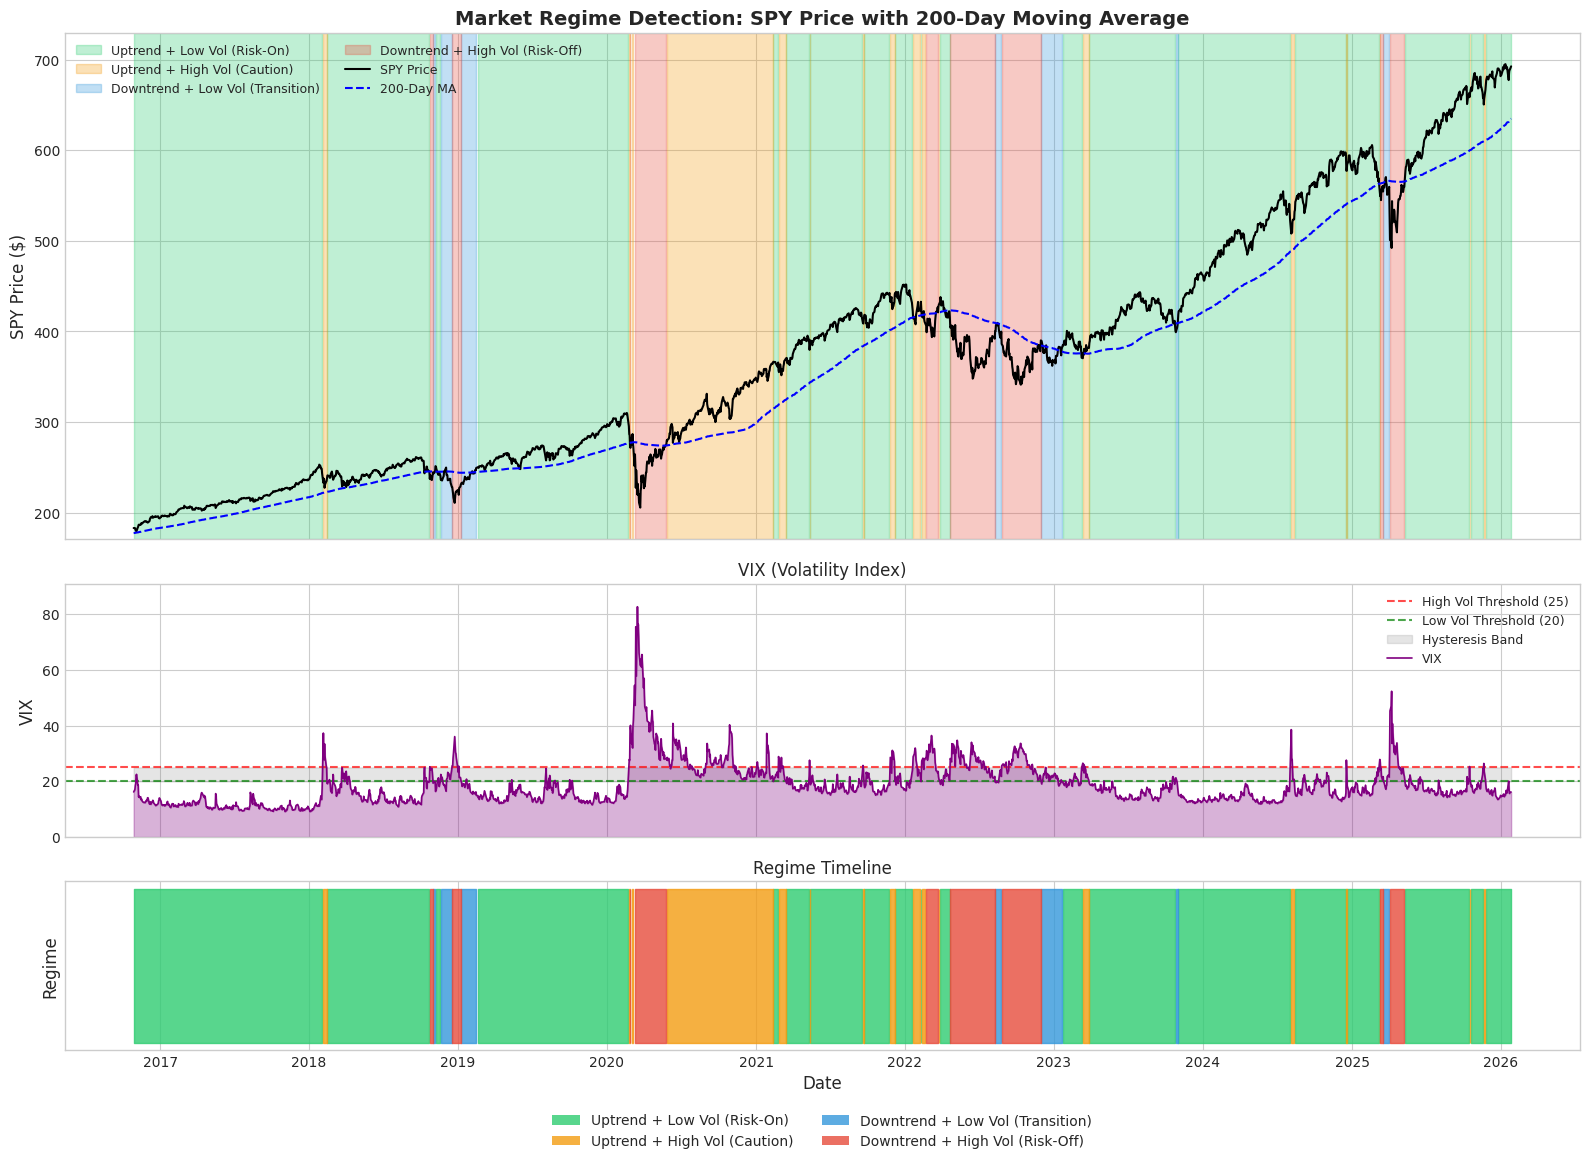

In [15]:
# Create the main visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                          gridspec_kw={'height_ratios': [3, 1.5, 1]})

# ============ Panel 1: SPY Price with 200MA and Regime Shading ============
ax1 = axes[0]

# Plot regime backgrounds
for regime, color in regime_colors.items():
    mask = regime_df['regime'] == regime
    ax1.fill_between(regime_df.index, regime_df['spy_price'].min() * 0.95,
                     regime_df['spy_price'].max() * 1.05,
                     where=mask, color=color, alpha=0.3, label=regime_labels[regime])

# Plot SPY price and 200MA
ax1.plot(regime_df.index, regime_df['spy_price'], 'k-', linewidth=1.5, label='SPY Price')
ax1.plot(regime_df.index, regime_df['spy_200ma'], 'b--', linewidth=1.5, label='200-Day MA')

ax1.set_ylabel('SPY Price ($)', fontsize=12)
ax1.set_title('Market Regime Detection: SPY Price with 200-Day Moving Average', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.set_ylim(regime_df['spy_price'].min() * 0.95, regime_df['spy_price'].max() * 1.05)

# ============ Panel 2: VIX with Threshold Bands ============
ax2 = axes[1]

# Plot VIX thresholds
ax2.axhline(y=25, color='red', linestyle='--', alpha=0.7, label='High Vol Threshold (25)')
ax2.axhline(y=20, color='green', linestyle='--', alpha=0.7, label='Low Vol Threshold (20)')
ax2.fill_between(regime_df.index, 20, 25, alpha=0.2, color='gray', label='Hysteresis Band')

# Plot VIX
ax2.plot(regime_df.index, regime_df['vix'], 'purple', linewidth=1.2, label='VIX')
ax2.fill_between(regime_df.index, regime_df['vix'], alpha=0.3, color='purple')

ax2.set_ylabel('VIX', fontsize=12)
ax2.set_title('VIX (Volatility Index)', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_ylim(0, regime_df['vix'].max() * 1.1)

# ============ Panel 3: Regime Timeline ============
ax3 = axes[2]

# Create numeric regime encoding for bar plot
regime_numeric = {
    'uptrend_low_vol': 4,
    'uptrend_high_vol': 3,
    'downtrend_low_vol': 2,
    'downtrend_high_vol': 1,
}
regime_df['regime_num'] = regime_df['regime'].map(regime_numeric)

# Plot colored bars for each day
for regime, color in regime_colors.items():
    mask = regime_df['regime'] == regime
    num = regime_numeric[regime]
    ax3.fill_between(regime_df.index, 0, 1, where=mask, color=color, alpha=0.8)

ax3.set_ylabel('Regime', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_title('Regime Timeline', fontsize=12)
ax3.set_yticks([])

# Create legend for regimes
legend_elements = [Patch(facecolor=color, alpha=0.8, label=regime_labels[regime])
                   for regime, color in regime_colors.items()]
ax3.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.3),
           ncol=2, fontsize=10)

# Format x-axis
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
output_path = Path.cwd().parent / "artifacts" / "regime_detection_chart.png"
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"Chart saved to: {output_path}")

plt.show()

## 6. Detailed Yearly Breakdown

In [16]:
# Yearly regime breakdown
regime_df['year'] = regime_df.index.year

yearly_stats = regime_df.groupby(['year', 'regime']).size().unstack(fill_value=0)
yearly_pcts = yearly_stats.div(yearly_stats.sum(axis=1), axis=0) * 100

print("Yearly Regime Distribution (%):")
print("=" * 80)
print(yearly_pcts.round(1).to_string())

Yearly Regime Distribution (%):
regime  downtrend_high_vol  downtrend_low_vol  uptrend_high_vol  uptrend_low_vol
year                                                                            
2016                   0.0                0.0               0.0            100.0
2017                   0.0                0.0               0.0            100.0
2018                   6.0                8.8               2.8             82.5
2019                   2.0               10.7               0.0             87.3
2020                  22.1                0.0              64.0             13.8
2021                   0.0                0.0              21.4             78.6
2022                  65.7               13.1               8.4             12.7
2023                   0.0                6.8               4.4             88.8
2024                   0.0                0.0               3.2             96.8
2025                  12.8                4.4               2.4             8

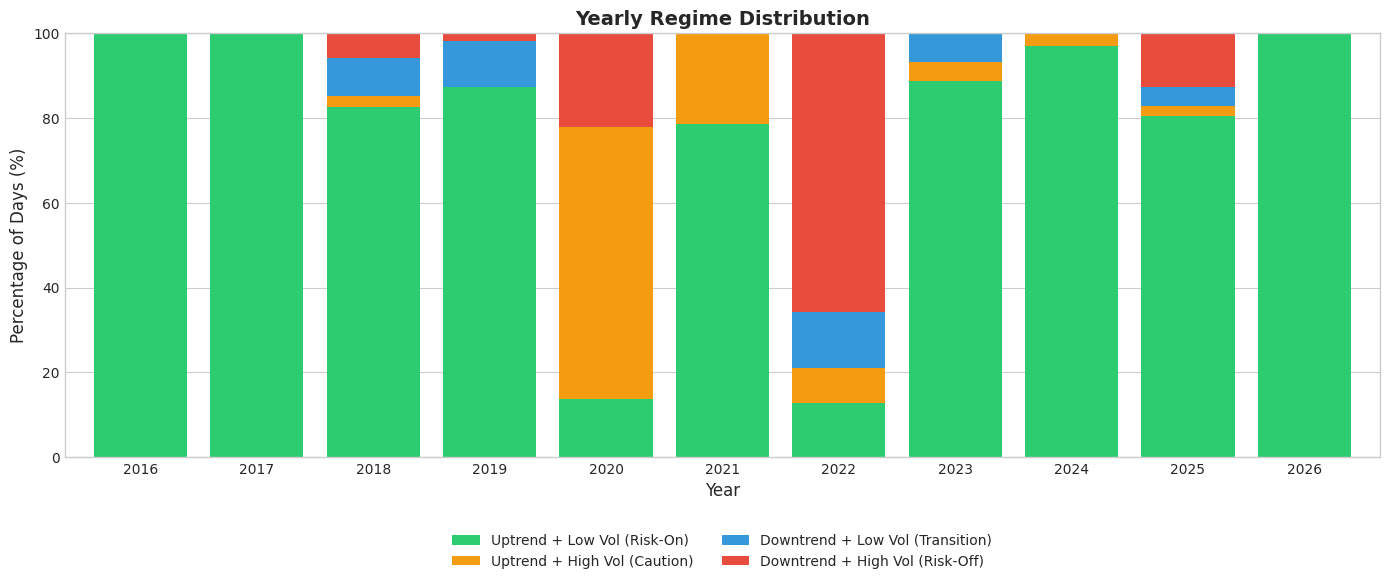

In [17]:
# Plot yearly regime breakdown as stacked bar chart
fig, ax = plt.subplots(figsize=(14, 6))

# Reorder columns for consistent stacking
order = ['uptrend_low_vol', 'uptrend_high_vol', 'downtrend_low_vol', 'downtrend_high_vol']
yearly_pcts_ordered = yearly_pcts.reindex(columns=[c for c in order if c in yearly_pcts.columns])

yearly_pcts_ordered.plot(kind='bar', stacked=True, ax=ax,
                         color=[regime_colors[c] for c in yearly_pcts_ordered.columns],
                         width=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Days (%)', fontsize=12)
ax.set_title('Yearly Regime Distribution', fontsize=14, fontweight='bold')
ax.legend([regime_labels[c] for c in yearly_pcts_ordered.columns],
          loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)
ax.set_ylim(0, 100)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(Path.cwd().parent / "artifacts" / "regime_yearly_breakdown.png",
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 7. SPY Returns by Regime

In [18]:
# Calculate daily returns
regime_df['spy_return'] = regime_df['spy_price'].pct_change()

# Calculate stats by regime
regime_return_stats = regime_df.groupby('regime')['spy_return'].agg([
    ('mean_daily', 'mean'),
    ('std_daily', 'std'),
    ('count', 'count'),
    ('total_return', lambda x: (1 + x).prod() - 1),
]).round(4)

# Annualize
regime_return_stats['mean_annual'] = regime_return_stats['mean_daily'] * 252
regime_return_stats['std_annual'] = regime_return_stats['std_daily'] * np.sqrt(252)
regime_return_stats['sharpe'] = regime_return_stats['mean_annual'] / regime_return_stats['std_annual']

print("SPY Performance by Regime:")
print("=" * 80)
print(regime_return_stats[['count', 'mean_annual', 'std_annual', 'sharpe', 'total_return']].round(3).to_string())

SPY Performance by Regime:
                    count  mean_annual  std_annual  sharpe  total_return
regime                                                                  
downtrend_high_vol    273        0.050       0.381   0.132        -0.035
downtrend_low_vol     110        0.176       0.173   1.019         0.072
uptrend_high_vol      269        0.101       0.221   0.457         0.081
uptrend_low_vol      1669        0.202       0.114   1.764         2.387


/tmp/ipykernel_10749/127161636.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, patch_artist=True, labels=[r.replace('_', '\n') for r in regime_order])


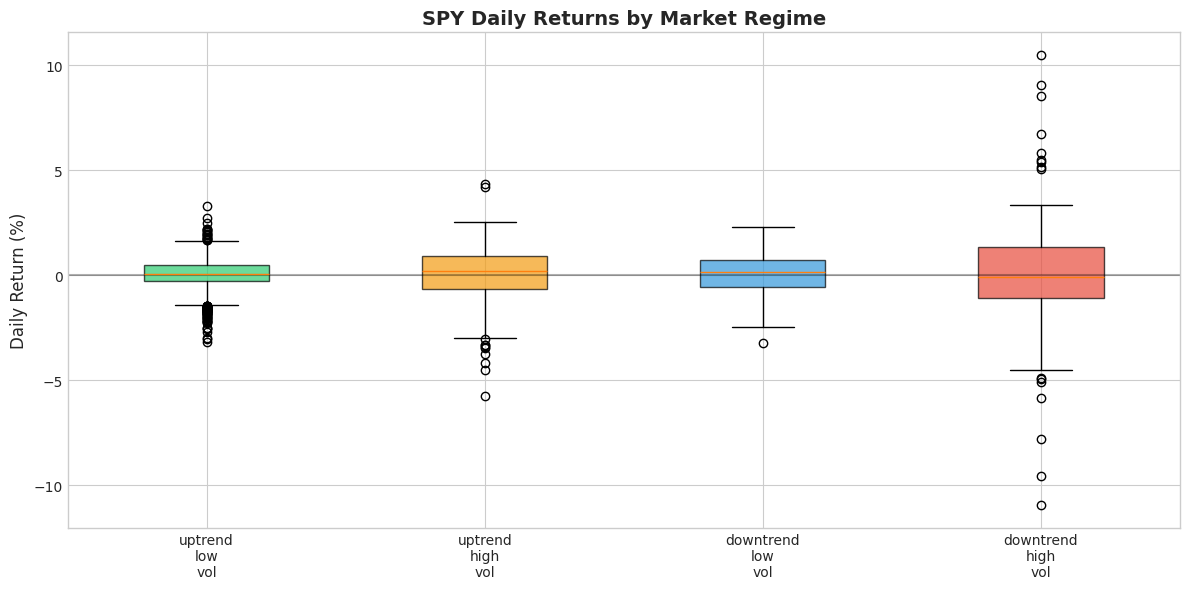

In [19]:
# Box plot of returns by regime
fig, ax = plt.subplots(figsize=(12, 6))

regime_order = ['uptrend_low_vol', 'uptrend_high_vol', 'downtrend_low_vol', 'downtrend_high_vol']
data_to_plot = [regime_df[regime_df['regime'] == r]['spy_return'].dropna() * 100 for r in regime_order]

bp = ax.boxplot(data_to_plot, patch_artist=True, labels=[r.replace('_', '\n') for r in regime_order])

for patch, regime in zip(bp['boxes'], regime_order):
    patch.set_facecolor(regime_colors[regime])
    patch.set_alpha(0.7)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_ylabel('Daily Return (%)', fontsize=12)
ax.set_title('SPY Daily Returns by Market Regime', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(Path.cwd().parent / "artifacts" / "regime_returns_boxplot.png",
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 8. Export Regime Data

In [20]:
# Export regime time series to parquet
export_df = regime_df[['regime', 'trend', 'volatility', 'spy_price', 'spy_200ma', 'vix']].copy()
export_path = Path.cwd().parent / "data" / "snapshots" / "regime_timeseries.parquet"
export_df.to_parquet(export_path)
print(f"Regime time series exported to: {export_path}")
print(f"Shape: {export_df.shape}")

Regime time series exported to: /workspaces/qetf/data/snapshots/regime_timeseries.parquet
Shape: (2322, 6)


In [21]:
# Show current regime
latest = regime_df.iloc[-1]
print(f"\n" + "=" * 60)
print(f"CURRENT MARKET REGIME (as of {latest.name.date()})")
print("=" * 60)
print(f"  Regime:     {latest['regime']}")
print(f"  Trend:      {latest['trend']}")
print(f"  Volatility: {latest['volatility']}")
print(f"  SPY Price:  ${latest['spy_price']:.2f}")
print(f"  SPY 200MA:  ${latest['spy_200ma']:.2f}")
print(f"  VIX:        {latest['vix']:.2f}")
print("=" * 60)


CURRENT MARKET REGIME (as of 2026-01-26)
  Regime:     uptrend_low_vol
  Trend:      uptrend
  Volatility: low_vol
  SPY Price:  $692.73
  SPY 200MA:  $634.96
  VIX:        16.15


## Summary

This notebook analyzed market regimes from 2016 to present using:
- **SPY price data** from `snapshot_latest` (200 ETF universe)
- **VIX data** from `macro.parquet` (FRED economic indicators)

The regime detection uses:
- **Trend**: SPY vs 200-day moving average with 2% hysteresis bands
- **Volatility**: VIX levels with 20/25 thresholds and hysteresis

Key outputs:
1. Daily regime time series chart (`artifacts/regime_detection_chart.png`)
2. Yearly regime breakdown (`artifacts/regime_yearly_breakdown.png`)
3. Returns by regime analysis (`artifacts/regime_returns_boxplot.png`)
4. Regime time series data (`data/snapshots/regime_timeseries.parquet`)